In [1]:
import os,cv2, keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Dense
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
annots = pd.read_csv("Annotations/frameAnnotationsBOX.csv")
annots_dict = {}
for row in annots.iterrows():
    x1 = int(row[1][0].split(";")[2])
    y1 = int(row[1][0].split(";")[3])
    x2 = int(row[1][0].split(";")[4])
    y2 = int(row[1][0].split(";")[5])
    filenum = ("daySequence2--00" + row[1][0].split(";")[7] + ".jpg")
    if filenum not in annots_dict:
        annots_dict[filenum] = [[x1, y1, x2, y2]]
    else:
        annots_dict[filenum].append([x1, y1, x2, y2])

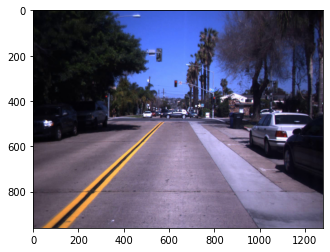

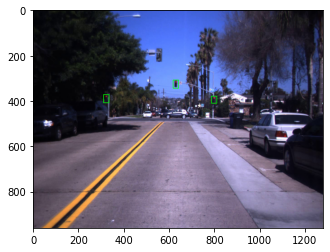

In [3]:
for step, i in enumerate(os.listdir("Images")):
    filename = "daySequence2--00275.jpg"
    image = cv2.imread(os.path.join("Images", filename))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for j in range (len(annots_dict[filename])):
        x1 = annots_dict[filename][j][0]
        y1 = annots_dict[filename][j][1]
        x2 = annots_dict[filename][j][2]
        y2 = annots_dict[filename][j][3]
        cv2.rectangle(image,(x1,y1),(x2,y2),(0, 255,0), 2)
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    break

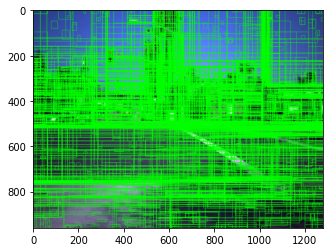

In [4]:
cv2.setUseOptimized(True) #включаем оптимизацию "железа"
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
image = cv2.imread("Images/daySequence2--00383.jpg")
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()
output_image = image.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [5]:
def iou_metrics(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [6]:
train_images=[]
train_labels=[]
for e, i in enumerate(os.listdir("Images")):
    try:
        if e > 100:
            break
        if i.startswith("daySequence2"):
            filename = i.split(".")[0]+".jpg"
            print(e, filename, "pending...")
            image = cv2.imread(os.path.join("Images", filename))
            coords=[]
            for j in range (len(annots_dict[filename])):
                x1 = annots_dict[filename][j][0]
                y1 = annots_dict[filename][j][1]
                x2 = annots_dict[filename][j][2]
                y2 = annots_dict[filename][j][3]
                coords.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            output_image = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for i in coords:
                        x,y,w,h = result
                        iou = iou_metrics(i,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.7:
                                temp_image = output_image[y:y+h,x:x+w]
                                resized = cv2.resize(temp_image, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                temp_image = output_image[y:y+h,x:x+w]
                                resized = cv2.resize(temp_image, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
                        
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 daySequence2--00270.jpg pending...
1 daySequence2--00271.jpg pending...
2 daySequence2--00272.jpg pending...
3 daySequence2--00273.jpg pending...
4 daySequence2--00274.jpg pending...
5 daySequence2--00275.jpg pending...
6 daySequence2--00276.jpg pending...
7 daySequence2--00277.jpg pending...
8 daySequence2--00278.jpg pending...
9 daySequence2--00279.jpg pending...
10 daySequence2--00280.jpg pending...
11 daySequence2--00281.jpg pending...
12 daySequence2--00282.jpg pending...
13 daySequence2--00283.jpg pending...
14 daySequence2--00284.jpg pending...
15 daySequence2--00285.jpg pending...
16 daySequence2--00286.jpg pending...
17 daySequence2--00287.jpg pending...
18 daySequence2--00288.jpg pending...
19 daySequence2--00289.jpg pending...
20 daySequence2--00290.jpg pending...
21 daySequence2--00291.jpg pending...
22 daySequence2--00292.jpg pending...
23 daySequence2--00293.jpg pending...
24 daySequence2--00294.jpg pending...
25 daySequence2--00295.jpg pending...
26 daySequence2--00296

In [35]:
X_new = np.array(train_images)
y_new = np.array(train_labels)
X_new.shape

(3108, 224, 224, 3)

In [9]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
for layers in (vggmodel.layers)[:15]:
    layers.trainable = False

In [11]:
X = vggmodel.layers[-2].output

In [12]:
predictions = Dense(2, activation="softmax")(X)

input1 = keras.Input(shape=(1,))
input2 = keras.Input(shape=(1,))

In [13]:
model_final = Model(inputs = vggmodel.input, outputs = predictions)

In [14]:
opt = adam_v2.Adam(learning_rate=0.0001)

In [15]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [16]:
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [18]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [19]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [20]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2797, 224, 224, 3) (311, 224, 224, 3) (2797, 2) (311, 2)


In [21]:
dataGen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
train_data = dataGen.flow(x=X_train, y=y_train)
test_data = dataGen.flow(x=X_test,y=y_test)

In [22]:
checkpoint = ModelCheckpoint("cnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [23]:
hist = model_final.fit_generator(generator= train_data, steps_per_epoch= 10, epochs= 5, validation_data= test_data, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\fenix\anaconda3\envs\hello-tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
10/10 [==============================] - 84s 8s/step - loss: 0.8028 - accuracy: 0.8656 - val_loss: 0.1975 - val_accuracy: 0.9062

Epoch 00001: val_loss improved from inf to 0.19749, saving model to cnn_vgg16_1.h5
Epoch 2/5
10/10 [==============================] - 77s 8s/step - loss: 0.0545 - accuracy: 0.9781 - val_loss: 0.0217 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.19749 to 0.02174, saving model to cnn_vgg16_1.h5
Epoch 3/5
10/10 [==============================] - 75s 8s/step - loss: 0.0155 - accuracy: 0.9937 - val_loss: 0.0628 - val_accuracy: 0.9844

Epoch 00003: val_loss did not improve from 0.02174
Epoch 4/5
10/10 [==============================] - 76s 8s/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.5907 - val_accuracy: 0.9531

Epoch 00004: val_loss did not improve from 0.02174
Epoch 5/5
10/10 [==============================] - 83s 8s/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0215 - val_accuracy: 1.0000

Epoch 00005: val_loss improv

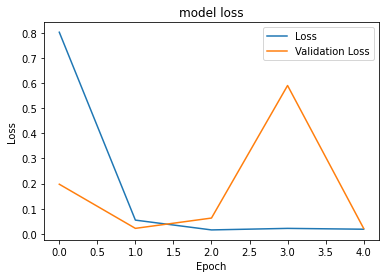

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [33]:
def detect_tr_lights(x):
        image = cv2.imread(x)
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        output_image = image.copy()

        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                temp_image = output_image[y:y+h,x:x+w]
                resized = cv2.resize(temp_image, (224,224), interpolation = cv2.INTER_AREA)
                image = np.expand_dims(resized, axis=0)
                out = model_final.predict(image)
                if out[0][0] > 0.80:
                    cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

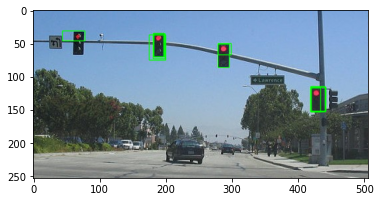

In [34]:
detect_tr_lights('Images/testing4.jpg')